# Mobile User Engagement EDA using Agent

## Import packages

In [30]:
%pip install langchain_openai
%pip install langchain_core
%pip install langchain_community
%pip install langchain_experimental
%pip install python-dotenv
%pip install pandas
%pip install matplotlib
%pip install plotly
%pip install nbformat
%pip install --upgrade nbformat
%pip install seaborn
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from langchain_openai.chat_models import ChatOpenAI
from langchain_experimental.utilities import PythonREPL
from typing import Annotated
from langchain_core.tools import tool
from langchain_core.prompts import PromptTemplate
import plotly.express as px


In [3]:
load_dotenv()

openai_key = os.environ.get("OPENAI_API")
gpt4o = ChatOpenAI(temperature=0.0, model="gpt-4", openai_api_key=openai_key)

## Read in data and extract metadata

In [4]:
# Create function that extracts metadata from data set
def extract_metadata(df):
    metadata = {}

    # Number of columns
    metadata['Number of Columns'] = df.shape[1]

    # Column names
    metadata['Schema'] = df.columns.tolist()

    # Data types of each column
    metadata['Data Types'] = str(df.dtypes)

    # Summary statistics
    metadata['Sample'] = df.head(1).to_dict(orient="records")

    return metadata

In [17]:
# read in csv file
df = pd.read_csv("../data/user_behavior_dataset.csv")
# run metadata extraction function
metadata = extract_metadata(df)

In [6]:
metadata

{'Number of Columns': 11,
 'Schema': ['User ID',
  'Device Model',
  'Operating System',
  'App Usage Time (min/day)',
  'Screen On Time (hours/day)',
  'Battery Drain (mAh/day)',
  'Number of Apps Installed',
  'Data Usage (MB/day)',
  'Age',
  'Gender',
  'User Behavior Class'],
 'Data Types': 'User ID                         int64\nDevice Model                   object\nOperating System               object\nApp Usage Time (min/day)        int64\nScreen On Time (hours/day)    float64\nBattery Drain (mAh/day)         int64\nNumber of Apps Installed        int64\nData Usage (MB/day)             int64\nAge                             int64\nGender                         object\nUser Behavior Class             int64\ndtype: object',
 'Sample': [{'User ID': 1,
   'Device Model': 'Google Pixel 5',
   'Operating System': 'Android',
   'App Usage Time (min/day)': 393,
   'Screen On Time (hours/day)': 6.4,
   'Battery Drain (mAh/day)': 1872,
   'Number of Apps Installed': 67,
   'Data Usage

I've been doing exploratory data analysis manually in Python for years, and I wanted to attempt to use an agent to help with this step, to see how well it would do. I followed the code and instructions from this Medium article (https://medium.com/@cubode/comprehensive-guide-using-ai-agents-to-analyze-and-process-csv-data-a0259e2af761), which uses the Langchain package, and the OpenAI API to help analyze data from a .csv file. In these first steps, I set up the agent and the prompts.

Overall, this step just prompts gpt to come up with charts or plots that it would use to visualize this data. The output lists several different types of plots that could be used to visualize and show relationships in this data. In general, the output gets it right...through a combination of bar charts, box plots, and scatter plots, as well as a correlation matrix, we can visualize the relationships between certain variables. We can also look at which of the variables are correlated or seem to be related to user activity categorization, which is our target variable, or the variable we are interested in trying to predict.

## Augment and engineer prompt for agent

In [34]:
# Create and engineer prompt used to prompt gpt for data visualization suggestions

openai_api_key = os.getenv("OPENAI_API")
if not openai_api_key:
    raise ValueError("OPENAI_API is not set correctly")

prompt_template = '''
Assistant is an AI model that takes in metadata from a dataset 
and suggests charts to use to visualize that data.

New Input: Suggest 7 charts to visualize data from a dataset with the following metadata. 


SCHEMA:

-------- 

{schema}

DATA TYPES: 

-------- 

{data_types}

SAMPLE: 

-------- 

{sample}

'''.format(schema = metadata["Schema"], data_types = metadata["Data Types"], sample=metadata["Sample"])

gpt4o.invoke(prompt_template)

AIMessage(content="1. **Bar Chart**: You can use a bar chart to visualize the distribution of 'Operating System'. This will show the number of users for each operating system.\n\n2. **Pie Chart**: A pie chart can be used to visualize the distribution of 'Gender'. This will show the proportion of male and female users.\n\n3. **Histogram**: A histogram can be used to visualize the distribution of 'Age'. This will show the number of users in each age group.\n\n4. **Scatter Plot**: A scatter plot can be used to visualize the relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'. This will show if there is a correlation between these two variables.\n\n5. **Box Plot**: A box plot can be used to visualize the distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'. This will show the variation in screen on time for different user behavior classes.\n\n6. **Heatmap**: A heatmap can be used to visualize the correlation between all the numerical variabl

## Have agent produce code that forms data structures for plots

This step sets up a function that can prompt the LLM to generate code for the charts described above. In order for the LLM to run Python code, it must use a Python REPL instance, which is basically a Python code processor.

Then this step sets up prompts that can go into the PromptTemplate function created by LangChain. The PromptTemplate function accepts parameters that can be used to generate a prompt for an LLM, in this case Open AI's GPT.

In [7]:
# Create an instance of PythonREPL
repl = PythonREPL()

# Pass the dataframe into the globals dictionary of the PythonREPL instance
repl.globals['df'] = df

In [8]:
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

tools = [python_repl]

In [9]:
# write prompt for instructions for agent to run the code it writes
instructions_template = '''

You are an agent that writes and excutes python code.

You have access to a Python abstract REPL, which you can use to execute the python code.

You must write the python code assuming that the dataframe (stored as df) has already been read.

If you get an error, debug your code and try again.

You might know the answer without running any code, but you should still run the code to get the answer.

If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.

Do not create example dataframes 
'''

In [11]:
base_template = '''

    {instructions_template}

    TOOLS:

    ------

    You have access to the following tools:

    {tools}

    To use a tool, please use the following format:

    ```

    Thought: Do I need to use a tool? Yes

    Action: the action to take, should be one of [{tool_names}]

    Action Input: the input to the action

    Observation: the result of the action

    ```

    When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

    ```

    Thought: Do I need to use a tool? No

    Final Answer: [your response here]

    ```

    Begin!

    Previous conversation history:

    {chat_history}

    New input: {input}

    {agent_scratchpad}
'''

In [12]:
base_prompt = PromptTemplate(template=base_template, input_variables=['agent_scratchpad', 'input', 'instructions', 'tool_names', 'tools'])
base_prompt = base_prompt.partial(instructions_template=instructions_template) #format the instructions

## Create Agent

A missing piece here is taking the output from the above step where ChatGPT helped us decide on what plots we should generate to analyze the data, and putting that output into the prompt. In this case, I copied and pasted the outputs from the above step, and then edited their format so that they fit neatly in this prompt, and so that the x-axis and y-axis were clear. In order to plug the outputs from above directly into this prompt, the prompt for the "Augment and Engineer Agent" step would need to be re-written and tested to output the data in a specific format. For accuracy reasons, I manually did that step.

The last step here uses LangChain's agent function, the prompt with instructions we created above, and the input descriptions of the plots to output code that could be used to take the data from the dataframe on mobile users and format it so that plots can be created.

In [13]:
new_input = '''
Create the data needed for the following chart

CHART 

-------- 
Chart 1: Bar Chart - Distribution of 'Operating Systems'

X-axis: Operating Systems

Y-axis: Count of Users for each Operating System\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 2: Pie chart - Distribution of 'Gender'

This will show the proportion of male and female users from the 'Gender' field.

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 3: Histogram - Distribution of 'Age'.

X-axis: Age

Y-axis: Count of Users for each Age\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 4: Scatter plot - Relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'.

X-axis: App Usage Time (min/day)

Y-axis: Battery Drain (mAh/day)\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 5: Box Plot - Distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'

X-axis: User Behavior Class

Y-axis: Screen On Time (hours/day)\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

-------- 
Chart 6: Heatmap - Correlation between all the numerical variables in the dataset.

X-axis: All numeric variables in the data set

Y-axis: All numeric variables in the data set\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

-------- 
Chart 7: Heatmap - Correlation between all the numerical variables in the dataset.

X-axis: All numeric variables in the data set

Y-axis: All numeric variables in the data set\n*

You're task is to write code to transform the raw data into the desired data structure in json to be included in the plot.

Only return the data.

Here is the dataset schema:

{schema}

'''.format(schema=metadata['Schema'])

In [14]:
from langchain.agents import AgentExecutor, create_react_agent

agent = create_react_agent(gpt4o, tools, base_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_out = agent_executor.invoke(
    {
        "input": new_input,
        "chat_history": ""
    }
)



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.


Thought: Do I need to use a tool? Yes

Action: python_repl

Action Input: 

```python
# Chart 1: Bar Chart - Distribution of 'Operating Systems'
os_distribution = df['Operating System'].value_counts().to_dict()

# Chart 2: Pie chart - Distribution of 'Gender'
gender_distribution = df['Gender'].value_counts().to_dict()

# Chart 3: Histogram - Distribution of 'Age'
age_distribution = df['Age'].value_counts().to_dict()

# Chart 4: Scatter plot - Relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'
scatter_data = df[['App Usage Time (min/day)', 'Battery Drain (mAh/day)']].to_dict('records')

# Chart 5: Box Plot - Distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'
box_plot_data = df.groupby('User Behavior Class')['Screen On Time (hours/day)'].apply(list).to_dict()

# Chart 6: Heatmap - Correlation between all the numerical variables in the dataset.
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_data = df

## Plot the charts

The last step of this exploratory analysis is to actually code and create the plots suggested above, with the data formats that the agent output above. It appears that the agent didn't provide the actual code for the plots, but just helped us to put the data into a format where we could use it to create plots. 

I like the plotly library most for creating plots, so I manually transferred the code for putting the data in the right format for each plot, and then wrote some code to produce plots here that would output the suggested plots using the matplotlib and plotly libraries.

In [26]:
df.columns

Index(['User ID', 'Device Model', 'Operating System',
       'App Usage Time (min/day)', 'Screen On Time (hours/day)',
       'Battery Drain (mAh/day)', 'Number of Apps Installed',
       'Data Usage (MB/day)', 'Age', 'Gender', 'User Behavior Class'],
      dtype='object')

In [28]:
df.shape

(700, 11)

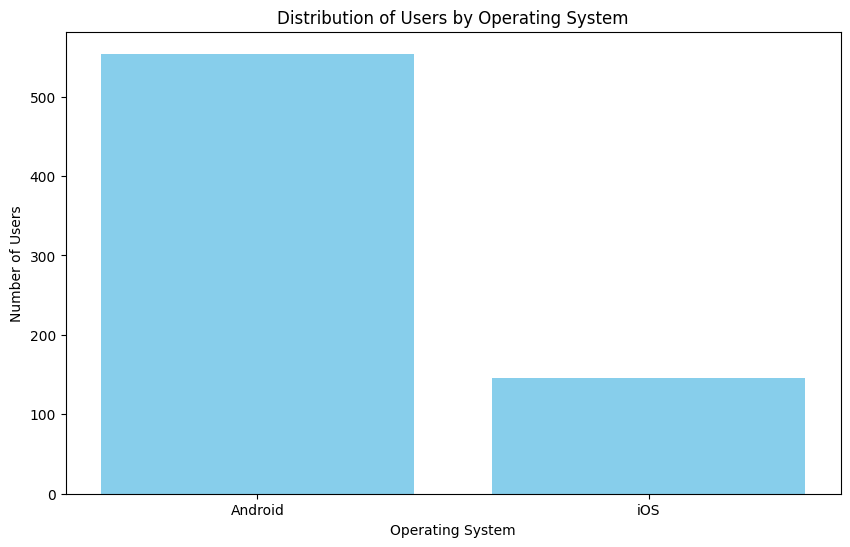

In [11]:
# Get operating system
os_distribution = df['Operating System'].value_counts().to_dict()

# Extract operating systems and their respective counts
operating_systems = list(os_distribution.keys())
user_counts = list(os_distribution.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(operating_systems, user_counts, color='skyblue')

# Add labels and title
plt.xlabel('Operating System')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Operating System')

# Display the chart
plt.show()


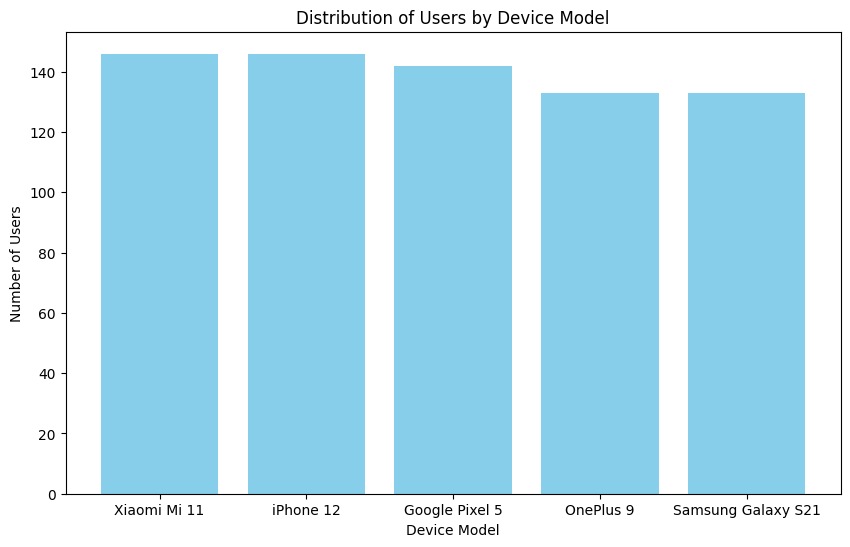

In [27]:
### I added this plot from my own curiosity

# Get device model 
dm_distribution = df['Device Model'].value_counts().to_dict()

# Extract device models and their respective counts
device_models = list(dm_distribution.keys())
user_counts = list(dm_distribution.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(device_models, user_counts, color='skyblue')

# Add labels and title
plt.xlabel('Device Model')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Device Model')

# Display the chart
plt.show()

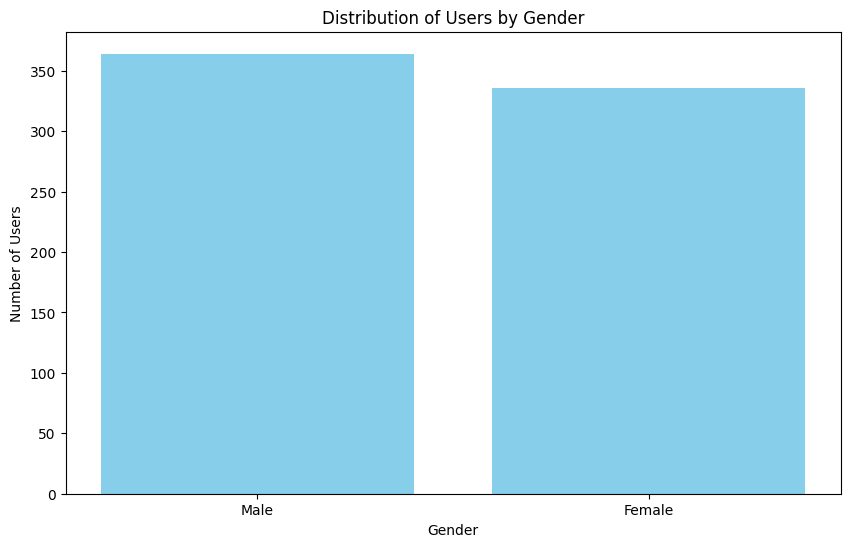

In [12]:
# Get gender data
gender_distribution = df['Gender'].value_counts().to_dict()

# Extract genders and their respective counts
gender_types = list(gender_distribution.keys())
user_counts = list(gender_distribution.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(gender_types, user_counts, color='skyblue')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Gender')

# Display the chart
plt.show()

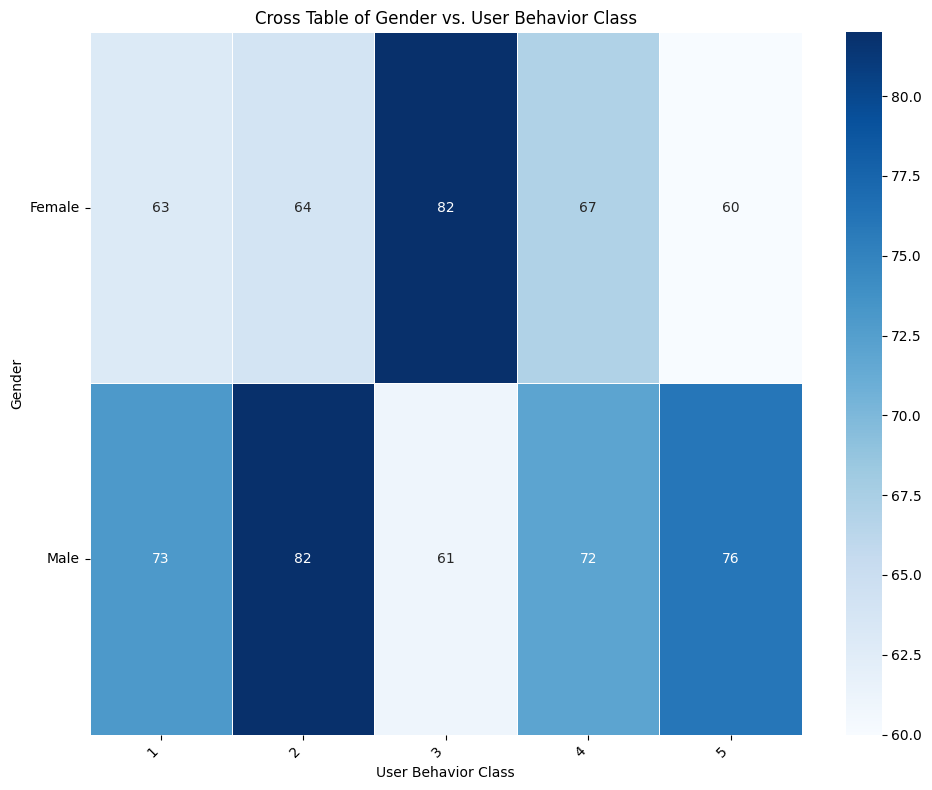

In [34]:
# Contingency table using pandas crosstab
cross_tab = pd.crosstab(df['Gender'], df['User Behavior Class'])

# Plot a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt="d", linewidths=.5)

# Customize the plot
plt.title('Cross Table of Gender vs. User Behavior Class')
plt.xlabel('User Behavior Class')
plt.ylabel('Gender')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
# Distribution of 'Age'
age_distribution = df['Age'].value_counts().to_dict()

# Create list of ages based on the distribution
ages = []
for age, count in age_distribution.items():
    ages.extend([age] * count)

# Convert the list of ages to a pandas DataFrame for Plotly
ages_df = pd.DataFrame(ages, columns=['Age'])

# Create a histogram using Plotly
fig = px.histogram(ages_df, 
                   x='Age', 
                   nbins=10,  # Number of bins
                   title='Distribution of Ages',
                   labels={'Age': 'Age'},
                   opacity=0.7)

# Customize layout (optional)
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Frequency',
    bargap=0.1  # Adjust the gap between bars
)

# Show the interactive histogram
fig.show()

In [35]:
# Box Plot - Distribution of 'Age' for each 'User Behavior Class'
box_plot_data = df.groupby('User Behavior Class')['Age'].apply(list).to_dict()

# Convert the dictionary into a DataFrame for Plotly
df_boxplot = pd.DataFrame({
    'User Behavior Class': [key for key in box_plot_data for _ in box_plot_data[key]],
    'Age': [value for values in box_plot_data.values() for value in values]
})

# Create the box plot using Plotly Express
fig = px.box(df_boxplot, 
             x='User Behavior Class', 
             y='Age', 
             title='Distribution of Age by User Behavior Class',
             labels={'User Behavior Class': 'User Behavior Class',
                     'Age': 'Screen On Time (hours/day)'})

# Customize layout (optional)
fig.update_layout(
    xaxis_title='User Behavior Class',
    yaxis_title='Age',
    boxmode='group'  # Group the boxes for each category
)

# Show the interactive box plot
fig.show()

In [14]:
# Chart 4: Scatter plot - Relationship between 'App Usage Time (min/day)' and 'Battery Drain (mAh/day)'
scatter_data = df[['App Usage Time (min/day)', 'Battery Drain (mAh/day)']].to_dict('records')

# Convert the list of dictionaries into a format Plotly can use
df_scatter = pd.DataFrame(scatter_data)

# Create scatter plot using Plotly Express
fig = px.scatter(df_scatter, 
                 x='App Usage Time (min/day)', 
                 y='Battery Drain (mAh/day)', 
                 title='App Usage Time vs. Battery Drain',
                 labels={'App Usage Time (min/day)': 'App Usage Time (min/day)', 
                         'Battery Drain (mAh/day)': 'Battery Drain (mAh/day)'})

# Show the interactive plot
fig.show()

In [19]:
# Chart 5: Box Plot - Distribution of 'Screen On Time (hours/day)' for each 'User Behavior Class'
box_plot_data = df.groupby('User Behavior Class')['Screen On Time (hours/day)'].apply(list).to_dict()

# Convert the dictionary into a DataFrame for Plotly
df_boxplot = pd.DataFrame({
    'User Behavior Class': [key for key in box_plot_data for _ in box_plot_data[key]],
    'Screen On Time (hours/day)': [value for values in box_plot_data.values() for value in values]
})

# Create the box plot using Plotly Express
fig = px.box(df_boxplot, 
             x='User Behavior Class', 
             y='Screen On Time (hours/day)', 
             title='Distribution of Screen On Time by User Behavior Class',
             labels={'User Behavior Class': 'User Behavior Class',
                     'Screen On Time (hours/day)': 'Screen On Time (hours/day)'})

# Customize layout (optional)
fig.update_layout(
    xaxis_title='User Behavior Class',
    yaxis_title='Screen On Time (hours/day)',
    boxmode='group'  # Group the boxes for each category
)

# Show the interactive box plot
fig.show()

In [25]:
# Chart 6: Heatmap - Correlation between all the numerical variables in the dataset.
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_data = df[numeric_columns].corr()

color_scale = [
    [0, 'blue'],  # -1 -> blue
    [0.5, 'grey'],  # 0 -> grey
    [1, 'red']  # 1 -> red
]

# Create a heatmap using Plotly with the custom color scale
fig = px.imshow(correlation_data, 
                text_auto=True,  # Display correlation values on the heatmap
                aspect="auto",   # Automatically adjusts the aspect ratio
                title="Correlation Matrix Heatmap",
                color_continuous_scale=color_scale,
                zmin=-1,  # Set minimum value for color scale
                zmax=1)   # Set maximum value for color scale

# Customize layout
fig.update_layout(
    xaxis_title="Numeric Columns",
    yaxis_title="Numeric Columns"
)

# Show the interactive heatmap
fig.show()

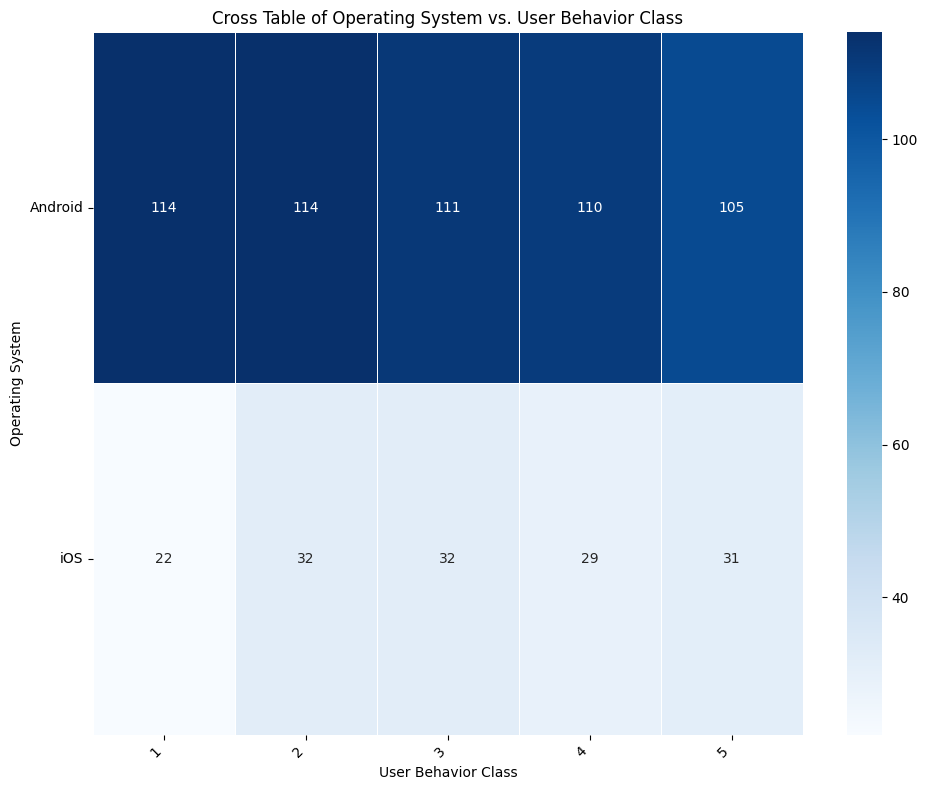

In [36]:
# Contingency table using pandas crosstab
cross_tab = pd.crosstab(df['Operating System'], df['User Behavior Class'])

# Heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt="d", linewidths=.5)

# Customize the plot
plt.title('Cross Table of Operating System vs. User Behavior Class')
plt.xlabel('User Behavior Class')
plt.ylabel('Operating System')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

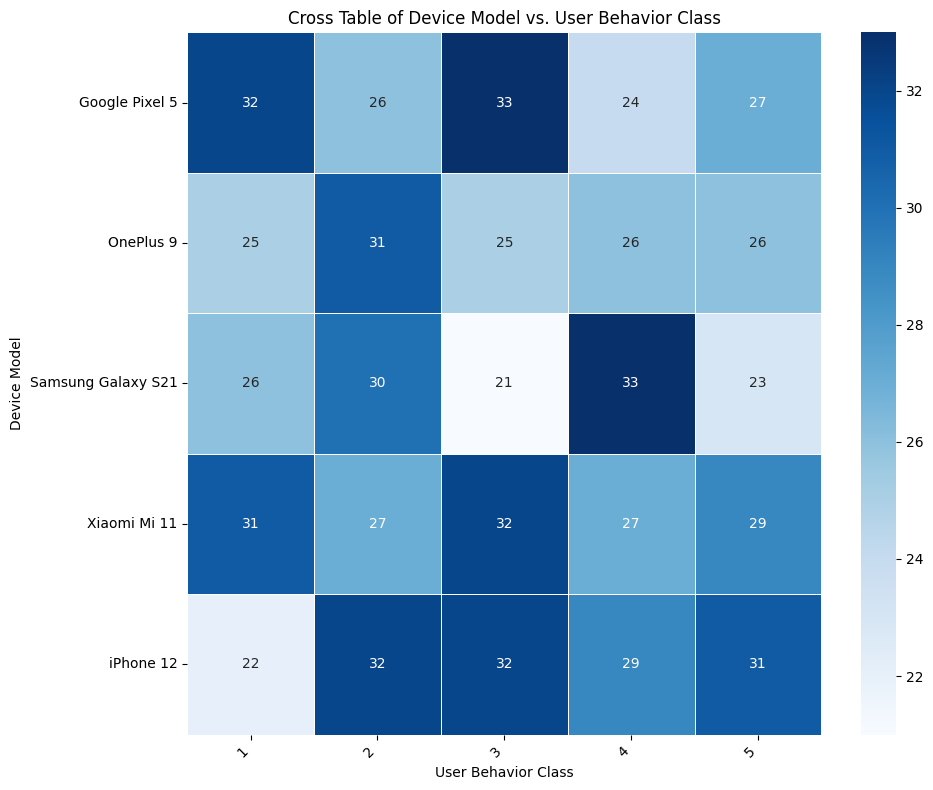

In [32]:
# Contingency table using pandas crosstab
cross_tab = pd.crosstab(df['Device Model'], df['User Behavior Class'])

# Heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="Blues", fmt="d", linewidths=.5)

# Customize the plot
plt.title('Cross Table of Device Model vs. User Behavior Class')
plt.xlabel('User Behavior Class')
plt.ylabel('Device Model')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


## Conclusion

Using a Langchain agent and ChatGPT, I was able to utilize an LLM to help guide us through the exploration of the data in the csv file on mobile users. Overall, it did a decent job of coming up with plots that would help us visualize the relationships of the data, but it fell short at completely coding the analysis for us. 

Although this isn't a fully comprehensive EDA, we can conclude a few things before moving on to building some models using this data. 

Firstly, the distribution of Android vs. OS users is skewed. We have about 1/3 of the OS users that we do Android users in the sample. I am curious to see how this plays out in predicting user behavior classes. When it comes to the device model, however, we have a more evenly distributed number of users across 5 different device models. From eye-balling the cross-tabs of Operating System and Device Model with User Behavior Class, the most noticable findings are that for Android users, the number of users in each class decreases as the user behavior increases. For OS users, it's the opposite. There are the least number of users in the lowest user behavior class, and higher numbers of users in the highest behavior classes. 

This trend is somewhat similar for the device models, but we see more variability in user behavior classes amongst Android devices. 

There is a pretty even distribution of genders and ages in the data sample, with slightly more males than females, and the lowest number of users under the age of 20.

A cross tab of gender with user behavior class shows that there is a trend where there are the most number of women in user behavior class 3, and the least number of men overall in user behavior class 3, which is makes gender a useful variable for potentially predicting user behavior class.

A box plot of age distributions across user behavior classes show that there is not much variability in median age across the different user behavior classes, but the median age in class 4 is slightly higher than the other classes, and the range of ages in classes 3 and 4 is wider.

App usage is very clearly correlated with battery drain based on the scatter plot.

Screen time is also very clearly correlated with user behavior class, with higher screen times directly resulting in higher user behavior. 

Most of the numeric variables, like App Usage, Number of Apps, Battery Drainage, Screen time, and data usage are all highly correlated with each other and with the target variable, user behavior class. This is to be expected, but because they are all so highly correlated with one another, models that take a simplistic approach to using these variables (for example, only using one variable to predict user behavior), or that find interactions between these variables, may perform better.

One thing that is important to note about these high correlations is that they potentially indicate something called "data leakage". This would be a very mild case of data leakage, but basically, the idea is that if you know a user's "Screen On Time", why do you need to know their User Behavior Class, since the two are so highly correlated? We will hypothesize on this some more in the modeling section.

Overall, we have completed some initial exploration of this data set, and we are ready to build a model that predicts user behavior class.

